In [2]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.8/61.8 MB 35.6 MB/s eta 0:00:00m eta 0:00:010:01:01

[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [100]:
# https://github.com/rasbt/mlxtend/blob/master/mlxtend/data/local_mnist.py

# Sebastian Raschka 2014-2022
# mlxtend Machine Learning Library Extensions
#
# A function for fetching the open-source MNIST dataset.
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

import struct

import numpy as np


def loadlocal_mnist(images_path, labels_path):
    """Read MNIST from ubyte files.

    Parameters
    ----------
    images_path : str
        path to the test or train MNIST ubyte file
    labels_path : str
        path to the test or train MNIST class labels file

    Returns
    --------
    images : [n_samples, n_pixels] numpy.array
        Pixel values of the images.
    labels : [n_samples] numpy array
        Target class labels

    Examples
    -----------
    For usage examples, please see
    http://rasbt.github.io/mlxtend/user_guide/data/loadlocal_mnist/

    """
    with open(labels_path, "rb") as lbpath:
        magic, n = struct.unpack(">II", lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, "rb") as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII", imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)

    return images, labels

In [101]:
X_train, y_train = loadlocal_mnist(
            images_path='train-images-idx3-ubyte', 
            labels_path='train-labels-idx1-ubyte')

X_test, y_test = loadlocal_mnist(
            images_path='t10k-images-idx3-ubyte', 
            labels_path='t10k-labels-idx1-ubyte')

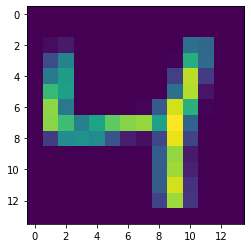

In [102]:
import cv2
import matplotlib.pyplot as plt
import math

downsampled_crop = 1
downsampled_size = 14

def downsample(imgs, size=downsampled_size, border_to_crop=downsampled_crop):
    original_dim = round(math.sqrt(imgs.shape[1]))
    twod_imgs = imgs.reshape((-1, original_dim, original_dim))
    cropped_imgs = twod_imgs[:, border_to_crop : -border_to_crop, border_to_crop : -border_to_crop]

    resized_images = np.stack([cv2.resize(cropped_img, (size, size), interpolation=cv2.INTER_AREA) for cropped_img in cropped_imgs])
    flattened_images = resized_images.reshape((-1, size**2))
    return flattened_images

downsampled_X_train = downsample(X_train)
downsampled_X_test  = downsample(X_test)

# plt.imshow(X_train[2].reshape((round(math.sqrt(X_train.shape[1])), round(math.sqrt(X_train.shape[1])))))
plt.imshow(downsampled_X_train[2].reshape((round(math.sqrt(downsampled_X_train.shape[1])), round(math.sqrt(downsampled_X_train.shape[1])))))

# Write Chunked JSON Data
## ...as .zip files

In [103]:
import json
import zipfile
import os

CHUNK_SIZE = 1000
REMOVE_JSON_FILES = True
ZIP_COMPRESSION = zipfile.ZIP_DEFLATED

INDEX_FILENAME = 'index.json'

outfile_zip_train = 'train-chunked.zip'
outfile_zip_test = 'test-chunked.zip'
outfile_downsampled_zip_train = f'train-{downsampled_size}x{downsampled_size}-chunked.zip'
outfile_downsampled_zip_test = f'test-{downsampled_size}x{downsampled_size}-chunked.zip'

# https://www.geeksforgeeks.org/break-list-chunks-size-n-python/
def do_chunk(l, n=CHUNK_SIZE):
    for i in range(0, len(l), n):
        yield l[i:i + n]

# -----------------------------

def writeChunkedFile(X, y, outFilename, chunk_size=CHUNK_SIZE):
    image_chunks = do_chunk(X)
    label_chunks = do_chunk(y)

    filenames = []
    for (idx, (image_chunk, label_chunk)) in enumerate(zip(image_chunks, label_chunks)):
        fname = f'data_{idx}.json'
        filenames.append(fname)

        with open(fname, 'w') as f:
            f.write(json.dumps({
                'images': image_chunk,
                'labels': label_chunk
            }))
            # print(f'Wrote file {fname}')

    with open(INDEX_FILENAME, 'w') as f:
        f.write(json.dumps({
            'files': filenames,
            'N': len(X)
        }))

    with zipfile.ZipFile(outFilename, 'w', ZIP_COMPRESSION) as zf:
        zf.write(INDEX_FILENAME)
        for fname in filenames:
            zf.write(fname)
        print(f'Wrote zipped train file {outFilename}')

    os.remove(INDEX_FILENAME)
    for fname in filenames:
        os.remove(fname)

writeChunkedFile(X_train.tolist(), y_train.tolist(), outfile_zip_train)
writeChunkedFile(X_test.tolist(), y_test.tolist(), outfile_zip_test)


writeChunkedFile(downsampled_X_train.tolist(), y_train.tolist(), outfile_downsampled_zip_train)
writeChunkedFile(downsampled_X_test.tolist(), y_test.tolist(), outfile_downsampled_zip_test)

Wrote zipped train file train-chunked.zip
Wrote zipped train file test-chunked.zip
Wrote zipped train file train-14x14-chunked.zip
Wrote zipped train file test-14x14-chunked.zip


# Write JSON Data
## ...as .zip files

In [70]:
# import json
# import zipfile
# import os

# REMOVE_JSON_FILES = True
# ZIP_COMPRESSION = zipfile.ZIP_DEFLATED

# outfile_train = 'train.json'
# outfile_zip_train = 'train.zip'
# outfile_test = 'test.json'
# outfile_zip_test = 'test.zip'

# # -----------------------------

# with open(outfile_train, 'w') as f:
#     f.write(json.dumps({
#         'images': X_train.tolist(),
#         'labels': y_train.tolist()
#     }))
#     print(f'Wrote train file {outfile_train}')
# with zipfile.ZipFile(outfile_zip_train, 'w', ZIP_COMPRESSION) as zf:
#     zf.write(outfile_train)
#     print(f'Wrote zipped train file {outfile_zip_train}')
    
# if REMOVE_JSON_FILES:
#     os.remove(outfile_train)
#     print(f'Removed uncompressed train file {outfile_train}')

# with open(outfile_test, 'w') as f:
#     f.write(json.dumps({
#         'images': X_test.tolist(),
#         'labels': y_test.tolist()
#     }))
#     print(f'Wrote test file {outfile_test}')
# with zipfile.ZipFile(outfile_zip_test, 'w', ZIP_COMPRESSION) as zf:
#     zf.write(outfile_test)
#     print(f'Wrote zipped test file {outfile_zip_test}')

# if REMOVE_JSON_FILES:
#     os.remove(outfile_test)
#     print(f'Removed uncompressed test file {outfile_test}')

Wrote train file train.json
Wrote zipped train file train.zip
Removed uncompressed train file train.json
Wrote test file test.json
Wrote zipped test file test.zip
Removed uncompressed test file test.json


# Write Tensorflow Data

In [14]:
# import tensorflow as tf

# train_tensor = tf.convert_to_tensor(X_train)
# train_label_tensor = tf.convert_to_tensor(y_train)

# test_tensor = tf.convert_to_tensor(X_test)
# test_label_tensor = tf.convert_to_tensor(y_test)

# train_dataset = tf.data.Dataset.from_tensors(train_tensor)


# # train_dataset.save('train-tensor')


# # tf.io.write_file('train-tensor', train_tensor)